# Analysis of Contact Tracing Applications

In [91]:
import re
from datetime import date, timedelta, datetime

import pandas as pd
import numpy as np

import scipy.stats as sps
import scipy.interpolate as spi
import statsmodels.api as sm
from pygam import LinearGAM, s, f, l

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import chart_studio as cs
import chart_studio.plotly as py

from tracking import config, utils

from IPython.display import display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pio.templates.default = "plotly_white"

In [3]:
sns.set(style='whitegrid', font_scale=1.5)

## Loading data

In [4]:
df_apps = pd.read_csv(config.data / 'all-apps.csv')
df_scores = pd.read_csv(config.data / 'apps_scored.csv')

In [5]:
utils.display_all(df_apps.head())

name    country who_region  \
0     CAuDHT        NaN        NaN   
1   Guardian        NaN        NaN   
2       Hi5X        NaN        NaN   
3   NinjaPad        NaN        NaN   
4  COVIDSafe  Australia       WPRO   

                                               links    platform  \
0              https://bit.ly/blecontacttracerdesign  mobile app   
1                       https://www.myguardian.life/  mobile app   
2                               https://hi5x-app.com  mobile app   
3         https://github.com/dantam/ninja-pad-python  mobile app   
4  https://www.health.gov.au/resources/apps-and-t...  mobile app   

       data_type bluetooth  gps qr_code centralized centralized_storage  \
0      bluetooth       yes   no      no         NaN                 NaN   
1            gps        no  yes      no         NaN                 NaN   
2  gps + QR code       yes  yes      no         NaN                 NaN   
3            gps        no  yes      no          no                  no   
4      bluetooth       yes   no      no         yes                 yes   

  central_id_storage central_contact_storage central_matching collect_pii  \
0                NaN                     NaN              NaN         NaN   
1                NaN                     NaN              NaN         yes   
2                NaN                     NaN              NaN         NaN   
3                 no                      no              NaN         NaN   
4                yes                      no              yes         yes   

        status date_proposed date_dev date_released date_cancelled  \
0     proposal           NaN      NaN           NaN     2020-04-18   
1  development           NaN      NaN           NaN            NaN   
2     released           NaN      NaN    2020-04-17            NaN   
3     proposed    2020-03-20      NaN           NaN     2020-04-22   
4     released    2020-04-14      NaN    2020-04-26            NaN   

           linkage_method   protocol   anon_method data_persistence_days  \
0                     NaN        NaN           NaN                   NaN   
1                     NaN        NaN           NaN                   NaN   
2                     NaN        NaN           NaN                   NaN   
3                     NaN        NaN           NaN                   NaN   
4  exchange temporary ids  BlueTrace  pseudonymous                    21   

  government contact_trace_aid opt_in_download opt_in_share  \
0        NaN               NaN             NaN          NaN   
1         no               yes             yes          NaN   
2        NaN               NaN             NaN          NaN   
3         no               yes             yes          yes   
4        yes               yes             yes          yes   

  quarantine_enforcement open_source encryption covid_positive_verification  \
0                     no         NaN        NaN                         NaN   
1                     no          no        NaN                         NaN   
2                     no         NaN        NaN                         NaN   
3                     no         yes        NaN                        test   
4                     no         yes        yes                        test   

   ios_downloads  android_downloads                     notes  \
0            NaN                NaN         Merged with Safe2   
1            NaN                NaN                       NaN   
2            NaN                NaN                       NaN   
3            NaN                NaN  seems to be discontinued   
4            NaN          1778000.0    based on TraceTogether   

   Installs on Google Play (greater than)  
0                                     NaN  
1                                     NaN  
2                                     NaN  
3                                     NaN  
4                                     NaN

In [6]:
utils.display_all(df_scores.head())

Name    Country                                              Links  \
0          Hi5X    unknown                               https://hi5x-app.com   
1     COVIDSafe  Australia  https://www.health.gov.au/resources/apps-and-t...   
2  Stopp Corona    Austria  https://www.roteskreuz.at/site/faq-app-stopp-c...   
3       BeAware    Bahrain  https://play.google.com/store/apps/details?id=...   
4  Covid Radius    Belgium  https://www.usine-digitale.fr/article/covid-19...   

  1.1. App has defined lifetime 1.2. Data storage is time-limited  \
0                       unknown                           21 days   
1                           yes                           21 days   
2                           yes                           14 days   
3                            no                                no   
4                            no                           14 days   

  2.1. Opt-in download and use 2.2. Opt-in data sharing  \
0                          yes                  unknown   
1                          yes                      yes   
2                          yes                      yes   
3                           no                       no   
4                           no                       no   

  2.3. Not tied to other benefits  \
0                         unknown   
1                             yes   
2                             yes   
3                              no   
4                              no   

  3.1. Data used only for establishing contacts 3.2. No PII collection  \
0                                       unknown                unknown   
1                                           yes                     no   
2                                           yes                    yes   
3                                            no                     no   
4                                           yes                     no   

  4.1. Open source 4.2. Published privacy policy 5.1. Freely available  \
0               no                            no                   yes   
1              yes                           yes                   yes   
2              yes                           yes                   yes   
3               no                            no                   yes   
4               no                            no                    no   

  5.2. Android and iOS (when necessary) 6.1. Decentralized storage  \
0                                  both                    unknown   
1                                  both                         no   
2                          android only                        yes   
3                          android only                         no   
4                                    no                         no   

  6.2. Can erase data 7.1. Decentralized matching  \
0             unknown                     unknown   
1                 yes                          no   
2                 yes                         yes   
3                  no                          no   
4                  no                          no   

  7.2. Rotating randomized beacon  \
0                         unknown   
1                             yes   
2                             yes   
3                              no   
4                              no   

  8.1. Contact accuracy (BLE, not GPS or other)  \
0                                 gps + qr code   
1                                           ble   
2                                           ble   
3                               gps + ebracelet   
4                                            no   

  8.2. Positive cases verified by test      protocol Installs (Google Play)  \
0                              unknown          none                    NaN   
1                                  yes          none              1,000,000   
2                     no (self-report)  Apple/Google                100,000   
3                                  yes          none   

In [7]:
df_merged = pd.merge(
    df_scores,
    df_apps[['name', 'who_region', 'platform', 'status', 'date_proposed', 'date_dev',
             'date_released', 'date_cancelled', 'government']],
    how='left',
    left_on='Name',
    right_on='name'
).drop('name', axis=1)

In [8]:
utils.display_all(df_merged.head())

Name    Country                                              Links  \
0          Hi5X    unknown                               https://hi5x-app.com   
1     COVIDSafe  Australia  https://www.health.gov.au/resources/apps-and-t...   
2  Stopp Corona    Austria  https://www.roteskreuz.at/site/faq-app-stopp-c...   
3       BeAware    Bahrain  https://play.google.com/store/apps/details?id=...   
4  Covid Radius    Belgium  https://www.usine-digitale.fr/article/covid-19...   

  1.1. App has defined lifetime 1.2. Data storage is time-limited  \
0                       unknown                           21 days   
1                           yes                           21 days   
2                           yes                           14 days   
3                            no                                no   
4                            no                           14 days   

  2.1. Opt-in download and use 2.2. Opt-in data sharing  \
0                          yes                  unknown   
1                          yes                      yes   
2                          yes                      yes   
3                           no                       no   
4                           no                       no   

  2.3. Not tied to other benefits  \
0                         unknown   
1                             yes   
2                             yes   
3                              no   
4                              no   

  3.1. Data used only for establishing contacts 3.2. No PII collection  \
0                                       unknown                unknown   
1                                           yes                     no   
2                                           yes                    yes   
3                                            no                     no   
4                                           yes                     no   

  4.1. Open source 4.2. Published privacy policy 5.1. Freely available  \
0               no                            no                   yes   
1              yes                           yes                   yes   
2              yes                           yes                   yes   
3               no                            no                   yes   
4               no                            no                    no   

  5.2. Android and iOS (when necessary) 6.1. Decentralized storage  \
0                                  both                    unknown   
1                                  both                         no   
2                          android only                        yes   
3                          android only                         no   
4                                    no                         no   

  6.2. Can erase data 7.1. Decentralized matching  \
0             unknown                     unknown   
1                 yes                          no   
2                 yes                         yes   
3                  no                          no   
4                  no                          no   

  7.2. Rotating randomized beacon  \
0                         unknown   
1                             yes   
2                             yes   
3                              no   
4                              no   

  8.1. Contact accuracy (BLE, not GPS or other)  \
0                                 gps + qr code   
1                                           ble   
2                                           ble   
3                               gps + ebracelet   
4                                            no   

  8.2. Positive cases verified by test      protocol Installs (Google Play)  \
0                              unknown          none                    NaN   
1                                  yes          none              1,000,000   
2                     no (self-report)  Apple/Google                100,000   
3                                  yes          none   

In [9]:
question2col = {
    '1.1. App has defined lifetime': '11_defined_lifetime',
    '1.2. Data storage is time-limited': '12_storage_time_limited',
    '2.1. Opt-in download and use': '21_opt_in_download_use',
    '2.2. Opt-in data sharing': '22_opt_in_share', 
    '2.3. Not tied to other benefits': '23_other_benefits',
    '3.1. Data used only for establishing contacts': '31_only_contacts',
    '3.2. No PII collection': '32_no_pii',
    '4.1. Open source': '41_open_source',
    '4.2. Published privacy policy': '42_privacy_policy',
    '5.1. Freely available': '51_free',
    '5.2. Android and iOS (when necessary)': '52_android_ios',
    '6.1. Decentralized storage': '61_decentralized_storage',
    '6.2. Can erase data': '62_erase_data',
    '7.1. Decentralized matching': '71_decentralized_matching',
    '7.2. Rotating randomized beacon': '72_rotating_randomized',
    '8.1. Contact accuracy (BLE, not GPS or other)': '81_ble_only',
    '8.2. Positive cases verified by test': '82_verify_test'
}
col2question = {c: q for q, c in question2col.items()}    

    
def replace_days(x):
    if x == 'no' or x == 'unknown':
        return x
    else:
        return 'yes'


def replace_data_use(x):
    if x == 'na':
        return 'unknown'
    elif x == 'yes':
        return 'yes'
    else:
        return 'no'

    
def replace_contact_accuracy(x):
    if x == 'ble':
        return 'yes'
    elif 'ble' in 'x':
        return 'unknown'
    elif x == 'unknown':
        return 'unknown'
    else:
        return 'no'
    

def replace_test(x):
    if x == 'na':
        return 'unknown'
    elif x in ['yes', 'unknown']:
        return x
    else:
        return 'no'
    

replace_dct = {
    'na': 'unknown',
    'no (WOM vouchers)': 'no',
    'maybe': 'unknown',
    'no (public spaces)': 'no',
    'maybe (blockchain)': 'unknown',
    'both': 'yes',
    'android only': 'yes',
    'iOS only': 'no'
}
replace_vals = {
    'no': 0,
    'maybe': 0,
    'unknown': 0,
    'yes': 1
}

df_coded = df_merged.rename(columns=question2col)
df_coded['has_protocol'] = df_coded['protocol'].apply(lambda x: 'yes' if x != 'none' else 'no')
df_coded['12_storage_time_limited'] = df_coded['12_storage_time_limited'].apply(replace_days)
df_coded['31_only_contacts'] = df_coded['31_only_contacts'].apply(replace_data_use)
df_coded['81_ble_only'] = df_coded['81_ble_only'].apply(replace_contact_accuracy)
df_coded['82_verify_test'] = df_coded['82_verify_test'].apply(replace_test)
for col in question2col.values():
    df_coded[col] = df_coded[col].replace(replace_dct).replace(replace_vals)

In [10]:
utils.display_all(df_coded)

Name          Country  \
0                                           Hi5X          unknown   
1                                      COVIDSafe        Australia   
2                                   Stopp Corona          Austria   
3                                        BeAware          Bahrain   
4                                   Covid Radius          Belgium   
5                                         Unmaze         Bulgaria   
6                                         Unmaze         Bulgaria   
7                                       ViruSafe         Bulgaria   
8                                ABTraceTogether           Canada   
9                                        ConTrac           Canada   
10                                          Covi           Canada   
11                                   COVID Alert           Canada   
12                                         flaat           Canada   
13                                       MyTrace           Canada   
14                                       MyTrace           Canada   
15   Alipay Health Code + Close Contact Detector            China   
16                                      CoronApp         Colombia   
17                                     CovTracer           Cyprus   
18                                       ERouška          Czechia   
19                                       Unnamed          Estonia   
20                                       CoCOVID               EU   
21                                       Epidose               EU   
22                                         Ketju          Finland   
23                              StopCovid France           France   
24                                    Stop Covid          Georgia   
25                               Corona-Warn-App          Germany   
26                                     Corona GO          Germany   
27                                      Coronika          Germany   
28                                        Cotect          Germany   
29                                           Ito          Germany   
30                                   my co:radar          Germany   
31                                         OHIOH          Germany   
32                                        Pandoa          Germany   
33                       GH COVID-19 Tracker App            Ghana   
34                         Covid Community Alert           Global   
35                                Stay Home Safe        Hong Kong   
36                                    VirusRadar          Hungary   
37                                  Rakning C-19          Iceland   
38                                  Aarogya Setu            India   
39                                   COVA Punjab            India   
40                   COVID-19 Quarantine Monitor            India   
41                                    Mahakavach            India   
42                              Quarantine Watch            India   
43                                        SAIYAM            India   
44                          SMC COVID-19 Tracker            India   
45                                         Tracy            India   
46                                        Unmaze            India   
47                                        Unmaze            India   
48                                PeduliLindungi        Indonesia   
49                                          AC19             Iran   
50                                       Mask.ir             Iran   
51                             COVID Tracker app          Ireland   
52                                   Code Orange           Israel   
53                                       HaMagen           Israel   
54                                   Track Virus           Israel   
55                                         diAry            Italy   
56                                        Immuni            Italy   
57                                    SM_C

In [11]:
def score_app(row):
    colnames = row.index
    total_score = 0.
    for i in range(1, 9):
        s = str(i)
        cols = [col for col in colnames if col.startswith(s)]
        max_col_score = len(cols)
        
        col_score = 0
        for j, col in enumerate(cols):
            j += 1
            col_score += row[col]
        col_score /= max_col_score
        total_score += col_score
    return total_score

In [12]:
df_scored = df_coded.assign(score=lambda df: df.apply(score_app, axis=1))

In [13]:
df_scored['score'].mean()

4.0578512396694215

In [14]:
utils.display_all(df_scored.sort_values('score', ascending=False))

Name          Country  \
51                             COVID Tracker app          Ireland   
113                                   SwissCOVID      Switzerland   
56                                        Immuni            Italy   
60                           Apturi Covid Latvia           Latvia   
88                                     Coalition    United States   
19                                       Unnamed          Estonia   
65                                      Wiqaytna          Morocco   
74                                  ProteGO Safe           Poland   
25                               Corona-Warn-App          Germany   
2                                   Stopp Corona          Austria   
100                                        COCOA            Japan   
78                                 TraceTogether        Singapore   
10                                          Covi           Canada   
89                                         CoEpi    United States   
105                                      WeTrace      Switzerland   
106                                      WeTrace      Switzerland   
8                                ABTraceTogether           Canada   
29                                           Ito          Germany   
96                          PathCheck SafePlaces    United States   
18                                       ERouška          Czechia   
110                                       Tabaud     Saudi Arabia   
1                                      COVIDSafe        Australia   
58                                  COVID19Radar            Japan   
112                                     BlueZone          Vietnam   
11                                   COVID Alert           Canada   
31                                         OHIOH          Germany   
120                                  Daancovid19          Senegal   
107                         Beat COVID Gibraltar        Gibraltar   
24                                    Stop Covid          Georgia   
32                                        Pandoa          Germany   
118                                     careFIJI             Fiji   
93                                         NOVID    United States   
12                                         flaat           Canada   
30                                   my co:radar          Germany   
21                                       Epidose               EU   
92                                   COVID Watch    United States   
80                                       Covi-ID     South Africa   
66                                 PrivateTracer      Netherlands   
53                                       HaMagen           Israel   
82                           Contact tracing app      Switzerland   
108                                  Virus Radar          Hungary   
68                                   StopKorona!  North Macedonia   
115                                   COVIDTrace         Malaysia   
59                                      AMAN App           Jordan   
37                                  Rakning C-19          Iceland   
57                                    SM_Covid19            Italy   
26                                     Corona GO          Germany   
95                                         Safe2    United States   
67                               NZ COVID Tracer      New Zealand   
85                                    TraceCovid              UAE   
97                                     SafeTrace    United States   
36                                    VirusRadar          Hungary   
17                                     CovTracer           Cyprus   
69                                   Smittestopp           Norway   
28                                        Cotect          Germany   
91                                   CoronaTrace    United States   
55                                         diAry            Italy   
87                                       N

In [15]:
df_scored['Country'].unique()

array(['unknown', 'Australia', 'Austria', 'Bahrain', 'Belgium',
       'Bulgaria', 'Canada', 'China', 'Colombia', 'Cyprus', 'Czechia',
       'Estonia', 'EU', 'Finland', 'France', 'Georgia', 'Germany',
       'Ghana', 'Global', 'Hong Kong', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Jordan', 'Latvia', 'Malaysia', 'Mexico', 'Morocco', 'Netherlands',
       'New Zealand', 'North Macedonia', 'Norway', 'Peru', 'Philippines',
       'Poland', 'Qatar', 'Russia', 'Saudi Arabia', 'Singapore',
       'Slovakia', 'South Africa', 'South Korea', 'Switzerland', 'Taiwan',
       'Thailand', 'UAE', 'Ukraine', 'United Kingdom', 'United States',
       'Viet Nam', 'Gibraltar', 'Kuwait', 'Tunisia', 'Vietnam', 'Fiji',
       'Senegal'], dtype=object)

In [16]:
len(df_scored['Country'].unique())

62

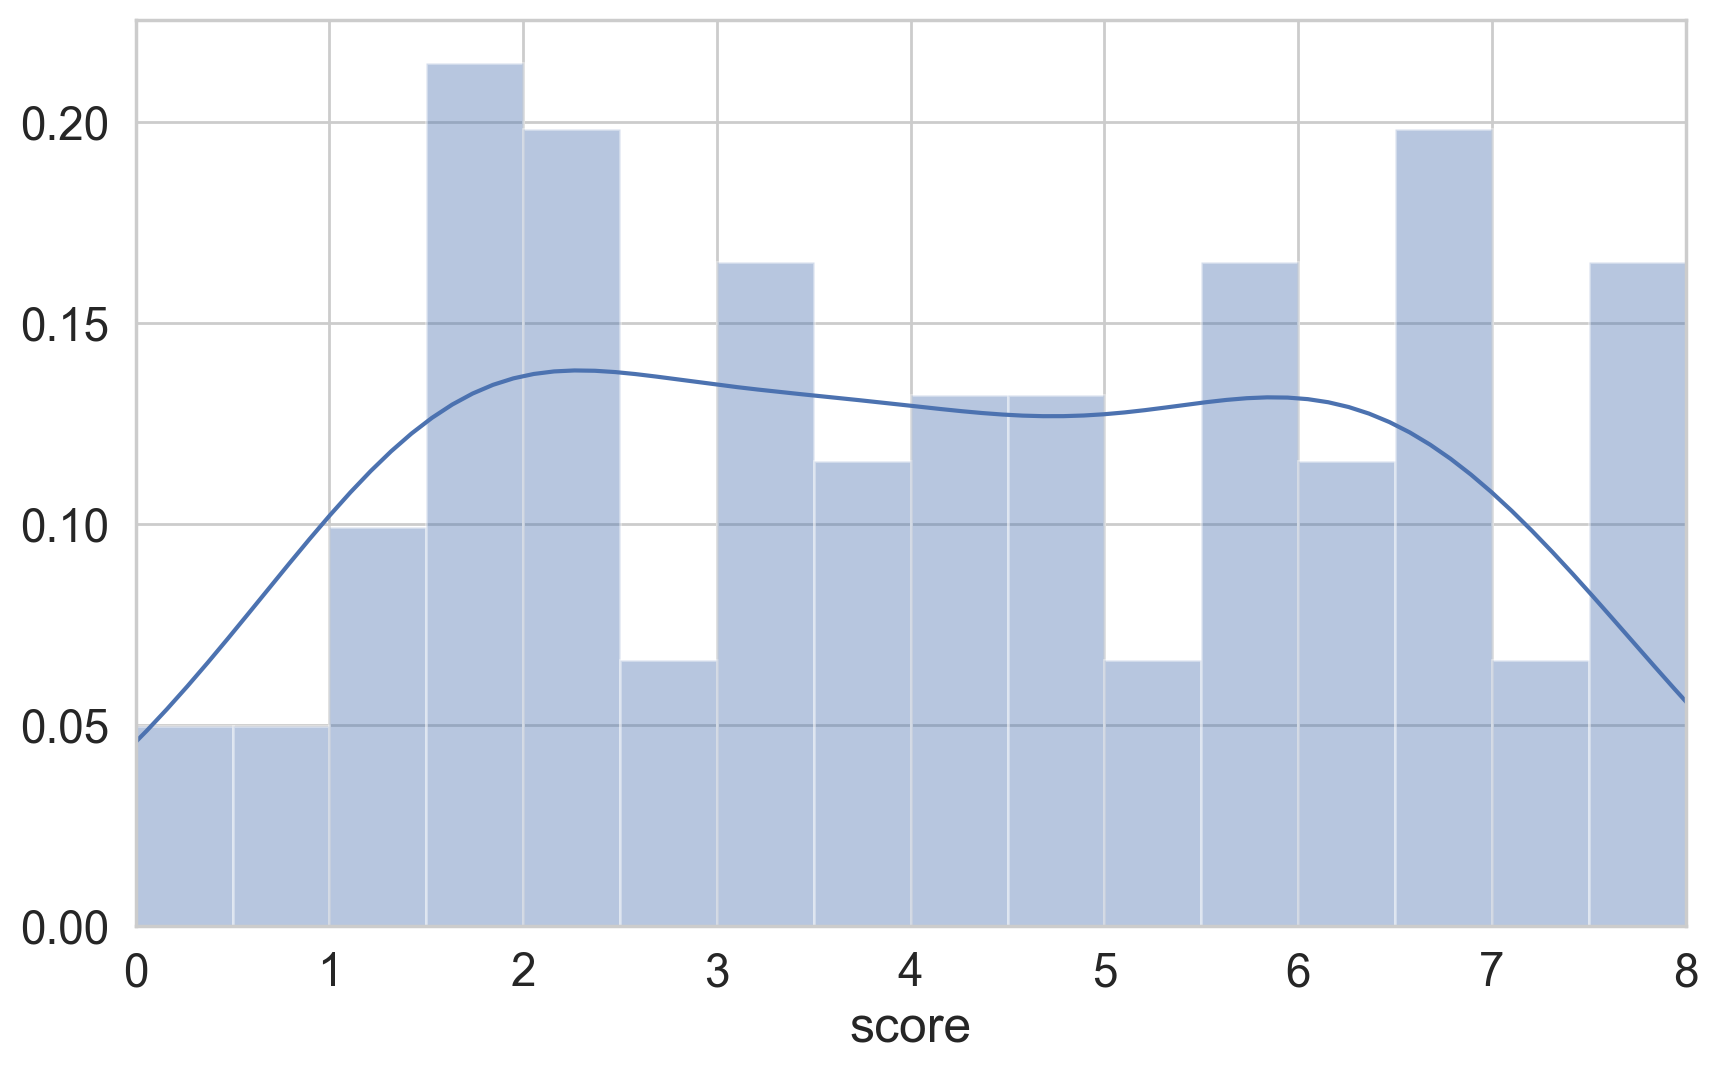

In [17]:
plt.figure(dpi=200, figsize=(10, 6))
sns.distplot(df_scored['score'], bins=16)
plt.xlim(0, 8);

In [18]:
df_gov = (df_scored[['government', 'score']]
          .groupby('government')
          .agg(['mean', 'std']))
df_protocol = (df_scored[['has_protocol', 'score']]
               .groupby('has_protocol')
               .agg(['mean', 'std']))
df_gov.columns = df_protocol.columns = ['mean', 'std']

In [19]:
df_gov

mean       std
government                    
no          4.319820  2.065434
yes         3.954545  2.194141

In [20]:
df_protocol

mean       std
has_protocol                    
no            3.172764  1.932050
yes           5.918803  1.437729

<ErrorbarContainer object of 3 artists>

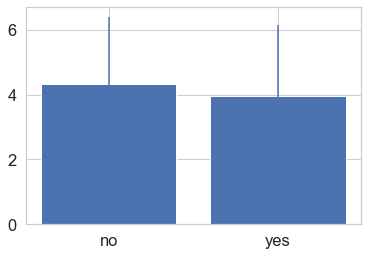

In [21]:
plt.bar(df_gov.index, df_gov['mean'])
plt.errorbar(df_gov.index, df_gov['mean'], yerr=df_gov['std'], fmt='none')

<ErrorbarContainer object of 3 artists>

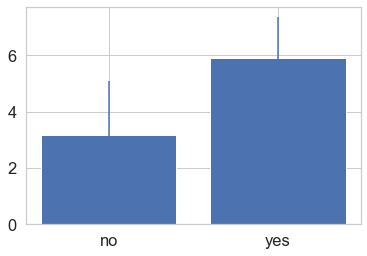

In [22]:
plt.bar(df_protocol.index, df_protocol['mean'])
plt.errorbar(df_protocol.index, df_protocol['mean'], yerr=df_protocol['std'], fmt='none')

In [23]:
(df_scored
 [['has_protocol', 'score']]
 .groupby('has_protocol')
 .agg(['mean', 'std']))

score          
                  mean       std
has_protocol                    
no            3.172764  1.932050
yes           5.918803  1.437729

In [24]:
df_scored['government'].value_counts()

yes    55
no     37
Name: government, dtype: int64

In [25]:
(df_scored['government'] == 'yes').mean()

0.45454545454545453

In [26]:
pd.crosstab(df_scored['has_protocol'], df_scored['government'])

government    no  yes
has_protocol         
no            23   41
yes           14   14

In [27]:
df_scored[['41_open_source', 'score']].groupby('41_open_source').agg('mean')

score
41_open_source          
0               2.929224
1               5.774306

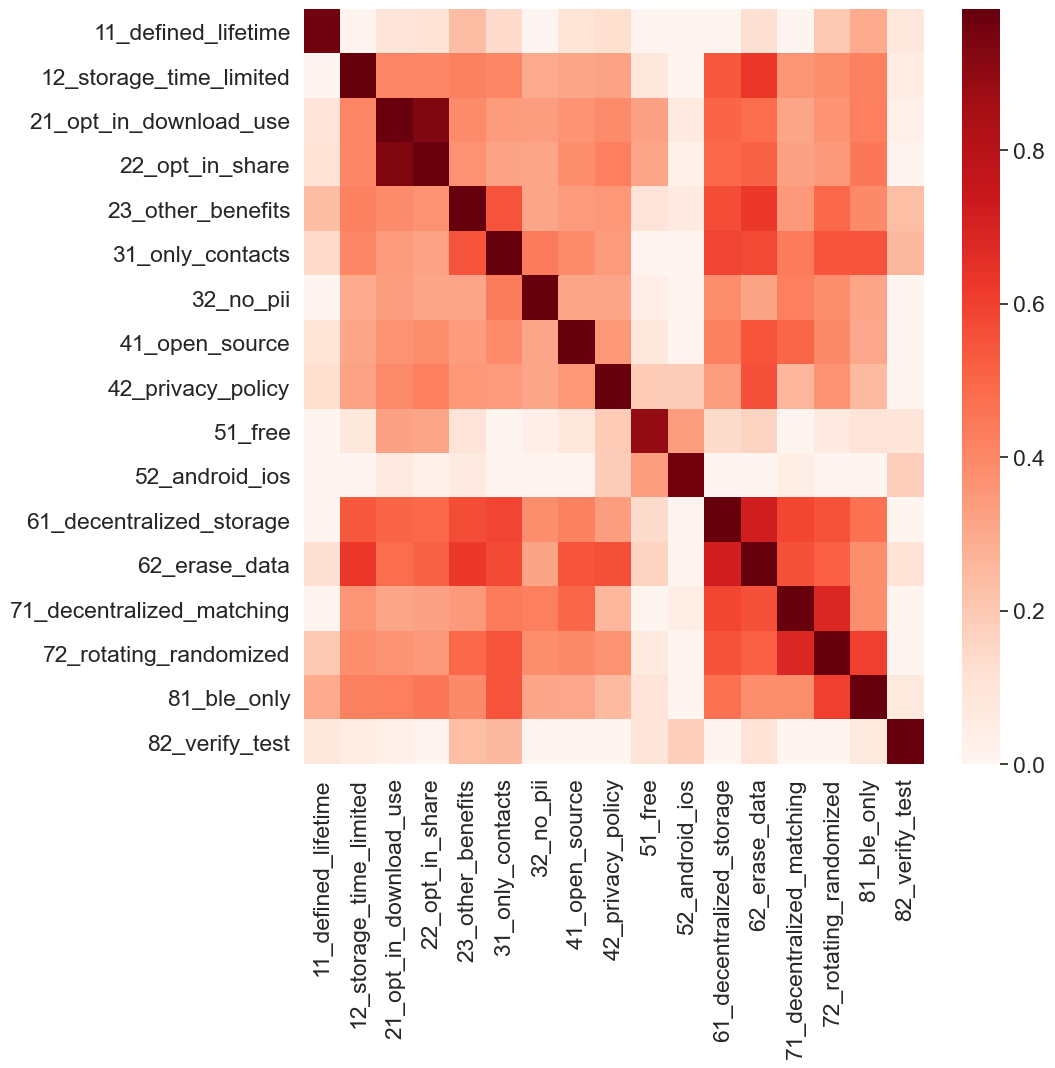

In [28]:
# Association between variables
feature_cols = list(question2col.values())
v_stats = np.zeros((len(feature_cols), len(feature_cols)), dtype=np.float32)
for i, c1 in enumerate(feature_cols):
    for j, c2 in enumerate(feature_cols):
        v_stats[i, j] = utils.cramers_v_corrected(df_scored[c1], df_scored[c2])

plt.figure(dpi=100, figsize=(10, 10))
sns.heatmap(v_stats, cmap='Reds')
plt.xticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=90);
plt.yticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=0);

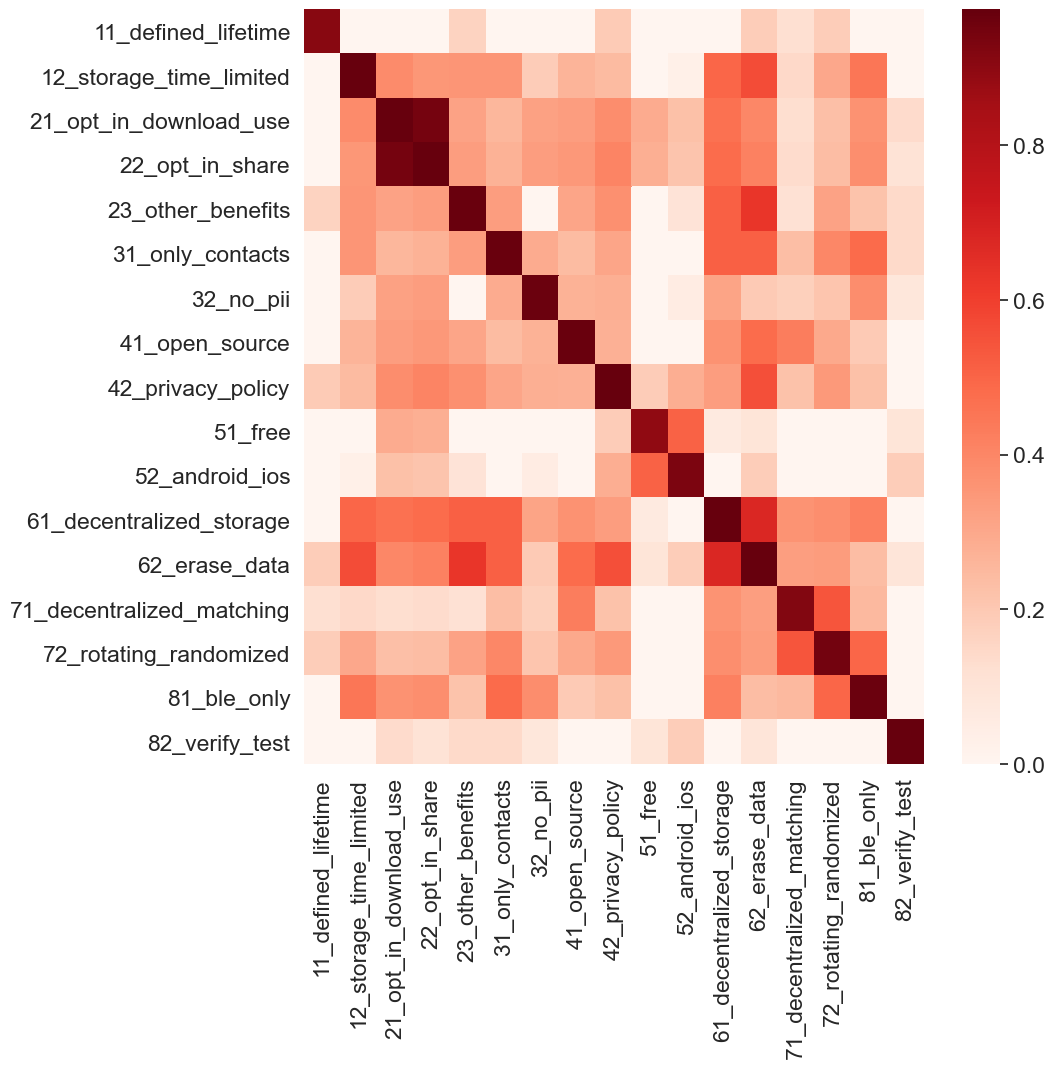

In [29]:
# Association between variables
subset = df_scored.query('has_protocol == "no"')
feature_cols = list(question2col.values())
v_stats = np.zeros((len(feature_cols), len(feature_cols)), dtype=np.float32)
for i, c1 in enumerate(feature_cols):
    for j, c2 in enumerate(feature_cols):
        if np.all(subset[c1] == 1) or np.all(subset[c2] == 1):
            continue
        v_stats[i, j] = utils.cramers_v_corrected(subset[c1], subset[c2])

plt.figure(dpi=100, figsize=(10, 10))
sns.heatmap(v_stats, cmap='Reds')
plt.xticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=90);
plt.yticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=0);

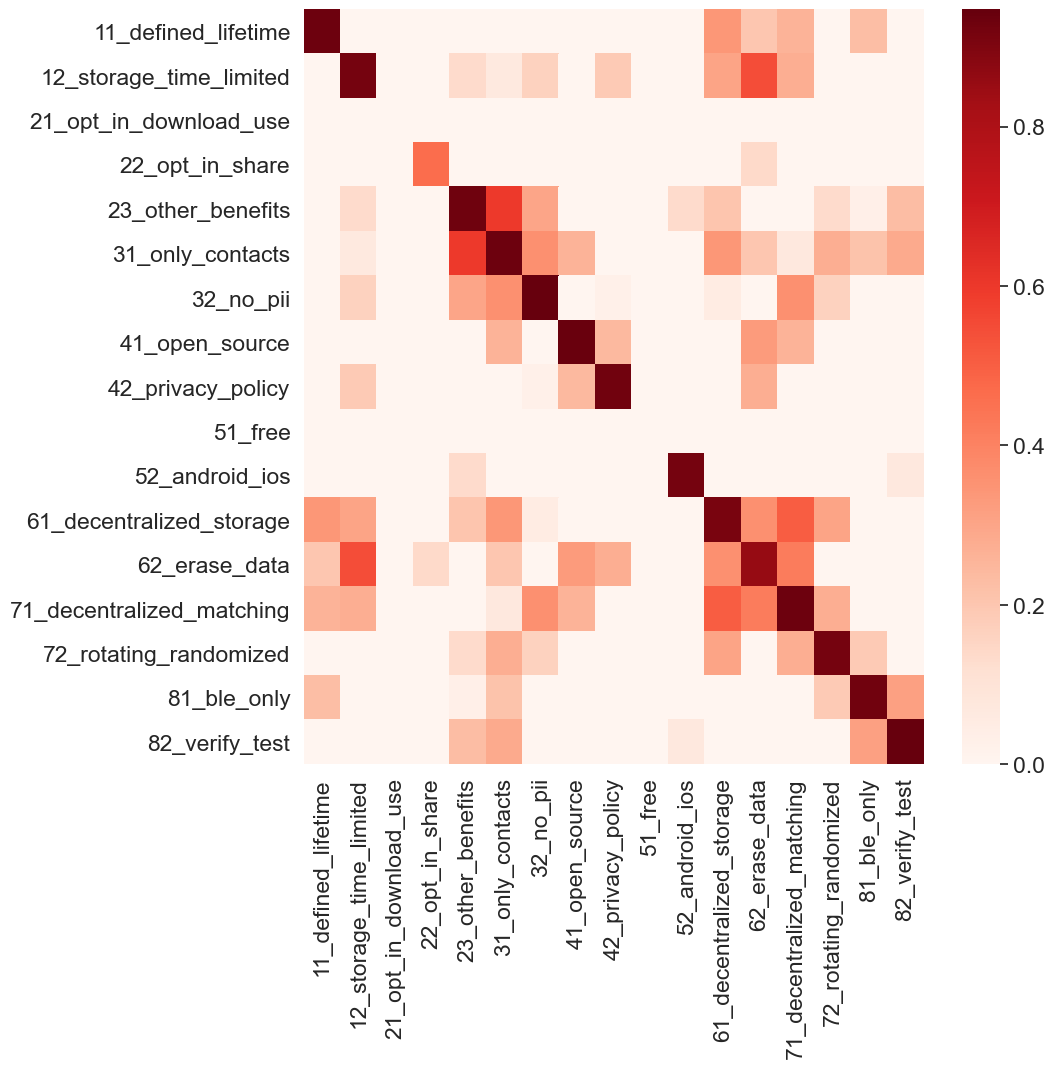

In [30]:
# Association between variables
subset = df_scored.query('has_protocol == "yes"')
feature_cols = list(question2col.values())
v_stats = np.zeros((len(feature_cols), len(feature_cols)), dtype=np.float32)
for i, c1 in enumerate(feature_cols):
    for j, c2 in enumerate(feature_cols):
        if np.all(subset[c1] == 1) or np.all(subset[c2] == 1):
            continue
        v_stats[i, j] = utils.cramers_v_corrected(subset[c1], subset[c2])

plt.figure(dpi=100, figsize=(10, 10))
sns.heatmap(v_stats, cmap='Reds')
plt.xticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=90);
plt.yticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=0);

Looking at the percentages for each sub-question, broken up by

- Overall
- Government
- Protocol
- Open source
- Country group (choose this)

In [31]:
df_scored[['11_defined_lifetime', 'government']].groupby('government').agg('mean')

11_defined_lifetime
government                     
no                     0.081081
yes                    0.218182

In [32]:
data = []
groupcols = ['government', 'has_protocol', '41_open_source']
for col in feature_cols + ['Number of apps', 'Average score']:

    # Total
    question = col if col in ['Number of apps', 'Average score'] else col2question[col]
    row = [question]
    
    if col == 'Number of apps':
        row.append(df_scored.shape[0])
    elif col == 'Average score':
        row.append(df_scored['score'].mean())
    else:
        row.append(np.mean(df_scored[col] == 1))
        question = col2question[col]
    
    for groupcol in groupcols:
        ix = np.logical_or(df_scored[groupcol] == 1, df_scored[groupcol] == 'yes')
        for i in [ix, ~ix]:
            if col == 'Number of apps':
                row.append(np.sum(i))
            elif col == 'Average score':
                row.append(np.mean(df_scored.loc[i, 'score']))
            else:
                row.append(np.mean(df_scored.loc[i, col] == 1))
                    
    data.append(row)

cols = pd.MultiIndex.from_tuples([
    ('Question',''), ('Total',''),
    ('Government', 'yes',), ('Government', 'no'),
    ('Protocol', 'yes'), ('Protocol', 'no'),
    ('Open_source', 'yes'), ('Open_source', 'no')
])
df_question_stats = pd.DataFrame(data, columns=cols).set_index(('Question', ''))
df_question_stats.index.name = 'Question'

/Users/benjaminlevy/Desktop/Benjamin/School/19_20/Classes/spring/ac221/final-project/covid-tracking-env/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [33]:
questions = list(question2col.keys())
lightred = sns.xkcd_palette(['light blue'])[0]
def style_proportion(a, color='light blue'):
    rgb = list(sns.xkcd_palette([color])[0])
    for i in range(len(rgb)):
        rgb[i] = int(rgb[i] * 255)
    r, g, b = rgb
    return f'background-color: rgba({r},{g},{b},{a})'
    
# df_question_stats[('question', '')] = list(col_rename.keys())
(df_question_stats
 .style
 .applymap(style_proportion, subset=pd.IndexSlice[questions, :])
 .format("{:.1%}", subset=pd.IndexSlice[questions, :])
 .format(lambda x: int(x), subset=pd.IndexSlice['Number of apps', :])
 .format("{:.2f}", subset=pd.IndexSlice['Average score', :]))

## Countries

In [34]:
displaydata = df_scored.query('government == "yes"').groupby('Country').agg({'score': ['mean', 'count']})
displaydata.columns = ['mean', 'count']
displaydata = displaydata.sort_values('mean', ascending=True)

In [35]:
displaydata

mean  count
Country                         
Hong Kong        1.000000      1
Viet Nam         1.000000      1
Qatar            1.000000      1
China            1.000000      1
Bahrain          1.500000      1
Ghana            1.666667      1
Kuwait           1.666667      1
India            1.809524      7
Russia           2.000000      1
Poland           2.000000      1
Peru             2.166667      1
Thailand         2.166667      1
Malaysia         2.583333      2
South Korea      2.666667      1
Israel           3.000000      1
Mexico           3.166667      1
Bulgaria         3.166667      1
Iran             3.166667      1
Colombia         3.666667      1
Indonesia        3.666667      1
Saudi Arabia     3.750000      2
Tunisia          4.166667      1
United Kingdom   4.166667      1
Norway           4.500000      1
Cyprus           4.500000      1
UAE              4.666667      1
New Zealand      4.666667      1
Iceland          5.000000      1
Hungary          5.000000      2
Jordan           5.166667      1
North Macedonia  5.500000      1
Canada           5.666667      3
Gibraltar        6.000000      1
Georgia          6.000000      1
Senegal          6.166667      1
Australia        6.500000      1
Czechia          6.500000      1
Vietnam          6.500000      1
Singapore        7.000000      1
Morocco          7.500000      1
Germany          7.500000      1
Austria          7.500000      1
Switzerland      8.000000      1
Italy            8.000000      1

In [36]:
subset

Name         Country  \
2            Stopp Corona         Austria   
8         ABTraceTogether          Canada   
11            COVID Alert          Canada   
12                  flaat          Canada   
16               CoronApp        Colombia   
17              CovTracer          Cyprus   
19                Unnamed         Estonia   
21                Epidose              EU   
23       StopCovid France          France   
24             Stop Covid         Georgia   
25        Corona-Warn-App         Germany   
26              Corona GO         Germany   
29                    Ito         Germany   
31                  OHIOH         Germany   
51      COVID Tracker app         Ireland   
56                 Immuni           Italy   
57             SM_Covid19           Italy   
60    Apturi Covid Latvia          Latvia   
62                MyTrace        Malaysia   
63                MyTrace        Malaysia   
66          PrivateTracer     Netherlands   
74           ProteGO Safe          Poland   
78          TraceTogether       Singapore   
82    Contact tracing app     Switzerland   
87                NHS App  United Kingdom   
88              Coalition   United States   
89                  CoEpi   United States   
91            CoronaTrace   United States   
92            COVID Watch   United States   
93                  NOVID   United States   
95                  Safe2   United States   
96   PathCheck SafePlaces   United States   
97              SafeTrace   United States   
100                 COCOA           Japan   
110                Tabaud    Saudi Arabia   
113            SwissCOVID     Switzerland   
118              careFIJI            Fiji   
119                Plinks         Germany   
120           Daancovid19         Senegal   

                                                 Links  11_defined_lifetime  \
2    https://www.roteskreuz.at/site/faq-app-stopp-c...                    1   
8    https://www.alberta.ca/ab-trace-together-priva...                    1   
11   https://www.cbc.ca/news/politics/contact-traci...                    1   
12                               https://app.flaat.io/                    0   
16   https://coronaviruscolombia.gov.co/test/aislam...                    0   
17                    https://covid-19.rise.org.cy/en/                    0   
19   https://e-estonia.com/trace-covid-19-while-res...                    0   
21               https://github.com/dspinellis/epidose                    0   
23   https://www.orange.com/en/content/download/541...                    1   
24   https://play.google.com/store/apps/details?id=...                    0   
25                         https://www.coronawarn.app/                    0   
26                               https://corona-go.de/                    1   
29                            https://www.ito-app.org/                    0   
31                                   https://ohioh.de/                    0   
51                        https://covidtracker.gov.ie/                    1   
56   https://www.nytimes.com/reuters/2020/04/17/tec...                    1   
57                          https://www.smcovid19.org/                    0   
60                          https://apturicovid.lv/#en                    0   
62            https://www.malaysiakini.com/news/523824                    1   
63            https://www.malaysiakini.com/news/523824                    1   
66                      https://www.privatetracer.org/                    0   
74   https://play.google.com/store/apps/details?id=...                    0   
78                   https://www.tracetogether.gov.sg/                    1   
82   https://lenews.ch/2020/05/14/swiss-government-...                    0   
87   https://play.google.com/store/apps/details?id=...                    0   
88                         http://CoalitionNetwork.org                    0   
89                               https://www.coepi.org                    0   
91      

In [37]:
fig = go.Figure()

hovertemplate = '''
<b>%{y}</b><br><br>
Average score: %{x}<br>
Number of apps: %{text}
<extra></extra>
'''

for query, color in zip(['mean < 0', 'mean >= 0'], ['orangered', 'lightblue']):
    subset = displaydata.query(query)
    fig.add_trace(
        go.Bar(
            x=subset['mean'],
            y=subset.index,
            text=subset['count'],
            orientation='h',
            hovertemplate=hovertemplate,
            marker_color=color,
            showlegend=False
        )
    )
    
fig.update_layout(
    xaxis={'title':'Average score'},
    title="Average country score for government-backed apps",
    width=1000,
    height=1000
)

fig.show()

In [38]:
py.plot(fig, filename='avg_country_score', auto_open=False)

'https://plotly.com/~benjaminlevy/3/'

## Time series

In [39]:
# Converting into a list where each element is a unique date with all the apps that existed on that date
start_date = date(2020, 2, 1) # February 1, 2020
end_date = date(2020, 7, 30) # July 1, 2020

days = {}
curr = start_date
while curr <= end_date:
    days[curr] = []
    curr += timedelta(days=1)

In [40]:
statuses = ['proposed', 'dev', 'released', 'cancelled']
for idx, row in df_scored.iterrows():
    dct = row.to_dict()
    app_statuses = []
    for status in statuses:
        status_date = dct[f'date_{status}']
        if not pd.isna(status_date):
            d = date(*[int(i) for i in status_date.split('-')])
            app_statuses.append((status, d))
    app_statuses.append(('end', end_date + timedelta(days=1)))
    
    for i in range(len(app_statuses) - 1):
        dct_cp = dct.copy()
        s, d0 = app_statuses[i]
        _, d1 = app_statuses[i + 1]
        dct_cp['status'] = s
        curr = d0
        while curr < d1:
            li = days[curr]
            li.append(dct_cp)
            days[curr] = li
            curr += timedelta(days=1)

In [41]:
def plot_time_series(groupvar, unknown=None, status=None, stacked=True, return_data=False):
    data = []
    for d, apps in days.items():
        row = {'date': d}
        for app in apps:
            if status is not None:
                if type(status) not in [list, tuple]:
                    status = [status]
                if app['status'] not in status:
                    continue
            level = app[groupvar]
            if unknown is not None or unknown == 'show':
                if level == 'unknown':
                    if unknown in ['drop', 'hide']:
                        continue
                    else:
                        level = unknown
            currval = row.get(level, 0)
            currval += 1
            row[level] = currval
        data.append(row)
    df_time = pd.DataFrame(data).fillna(0)
    if return_data:
        return df_time
    
    plt.figure(figsize=(16, 6), dpi=200)
    y0 = np.zeros(len(df_time))
    x = df_time['date']
    for level in np.sort(df_time.columns[1:]):
        y1 = df_time[level]
        plt.fill_between(x, y0, y1 + y0, label=level, alpha=0.4)
        if stacked:
            y0 += y1
    plt.legend(loc='upper left')
    if stacked:
        ymax = max(y0)
        plt.ylim(0, ymax)
    plt.xlim(start_date, end_date)
    plt.title(groupvar)
    plt.grid(b=None)
    ax = plt.gca()
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        

def plot_score_time_series(status=None, stacked=False):
    data = []
    for d, apps in days.items():
        row = {'date': d}
        day_total_score = 0.
        day_count = 0.
        for app in apps:
            if status is not None:
                if type(status) not in [list, tuple]:
                    status = [status]
                if app['status'] not in status:
                    continue
            day_total_score += app['score']
            day_count += 1.
        row['avg_score'] = day_total_score / day_count if day_count > 0 else 0
        data.append(row)
    df_time = pd.DataFrame(data).fillna(0)

    plt.figure(figsize=(16, 6), dpi=200)
    y0 = np.zeros(len(df_time))
    x = df_time['date']
    for level in np.sort(df_time.columns[1:]):
        y1 = df_time['avg_score']
        plt.fill_between(x, y0, y1 + y0, label=level, alpha=0.4)
        if stacked:
            y0 += y1
    plt.legend(loc='upper left')
    if stacked:
        ymax = max(y0)
        plt.ylim(0, ymax)
    plt.xlim(start_date, end_date)
    plt.title("Score over time")
    plt.grid(b=None)
    ax = plt.gca()
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        

In [42]:
displaydata = plot_time_series('has_protocol', status=['released', 'dev'],
                               stacked=True, unknown='drop', return_data=True)

fig = go.Figure()


for status, level, color in zip(['yes', 'no'], ["With protocol", "No protocol"], ['lightblue', 'orangered']):
    hovertemplate = level + ": %{y}<extra></extra>"
    fig.add_trace(go.Scatter(
        x=displaydata['date'],
        y=displaydata[status],
        mode='lines',
        hovertemplate=hovertemplate,
        line=dict(width=0.5, color=color),
        stackgroup='one',
        name=level
    ))
fig.update_layout(hovermode='x', 
                  yaxis={'title': "Number of apps"},
                  xaxis={'title': "Date"},
                  title="Apps released or in development with privacy-preserving protocol")
fig.show()

py.plot(fig, filename='protocol_time_series', auto_open=False)

'https://plotly.com/~benjaminlevy/5/'

In [43]:
displaydata = plot_time_series('41_open_source', status=['released', 'dev'],
                               stacked=True, unknown='drop', return_data=True)

fig = go.Figure()


for status, level, color in zip([1, 0],
                                ["Open source", "Not open source"],
                                ['#a6d854', 'lightgray']):
    hovertemplate = str(level) + ": %{y}<extra></extra>"
    fig.add_trace(go.Scatter(
        x=displaydata['date'],
        y=displaydata[status],
        mode='lines',
        hovertemplate=hovertemplate,
        line=dict(width=0.5, color=color),
        stackgroup='one',
        name=level
    ))
fig.update_layout(hovermode='x', 
                  yaxis={'title': "Number of apps"},
                  xaxis={'title': "Date"},
                  title="Open or closed-source apps released or in development")
fig.show()

py.plot(fig, filename='open_source_time_series', auto_open=False)

'https://plotly.com/~benjaminlevy/7/'

In [44]:
displaydata = plot_time_series('who_region', status=['released', 'dev'],
                               stacked=True, unknown='drop', return_data=True)

fig = go.Figure()

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for status, level, color in zip(['AFRO', 'NORAM', 'LATAM', 'SEARO', 'EURO', 'EMRO', 'WPRO'],
                                ['Africa', 'N. America', 'Latin America', 'S.E. Asia', 'EU', 'E. Mediterranean', 'W. Pacific'],
                                colors):
    hovertemplate = str(level) + ": %{y}<extra></extra>"
    fig.add_trace(go.Scatter(
        x=displaydata['date'],
        y=displaydata[status],
        mode='lines',
        hovertemplate=hovertemplate,
        line=dict(width=0.5, color=color),
        stackgroup='one',
        name=level
    ))
fig.update_layout(hovermode='x', 
                  yaxis={'title': "Number of apps"},
                  xaxis={'title': "Date"},
                  title="Apps released or in development by region")
fig.show()

py.plot(fig, filename='apps_by_region', auto_open=False, config=dict(displayModeBar=False))

'https://plotly.com/~benjaminlevy/27/'

In [56]:
np.vander(x, N=4)

array([[      0,       0,       0,       1],
       [   2744,     196,      14,       1],
       [   5832,     324,      18,       1],
       [  10648,     484,      22,       1],
       [  17576,     676,      26,       1],
       [  19683,     729,      27,       1],
       [  21952,     784,      28,       1],
       [  24389,     841,      29,       1],
       [  27000,     900,      30,       1],
       [  27000,     900,      30,       1],
       [  35937,    1089,      33,       1],
       [  46656,    1296,      36,       1],
       [  54872,    1444,      38,       1],
       [  54872,    1444,      38,       1],
       [  54872,    1444,      38,       1],
       [  68921,    1681,      41,       1],
       [  74088,    1764,      42,       1],
       [  74088,    1764,      42,       1],
       [  74088,    1764,      42,       1],
       [  79507,    1849,      43,       1],
       [  85184,    1936,      44,       1],
       [  91125,    2025,      45,       1],
       [  

In [59]:
X = np.vander(x, N=4)
model = sm.OLS(y, X).fit()
yhat = model.predict(np.vander(xx, N=4))

In [60]:
yhat

array([4.85326646, 4.48973794, 4.17057148, 3.89398815, 3.65820905,
       3.46145524, 3.3019478 , 3.17790781, 3.08755634, 3.02911447,
       3.00080329, 3.00084386, 3.02745727, 3.07886459, 3.15328689,
       3.24894527, 3.36406078, 3.49685452, 3.64554755, 3.80836096,
       3.98351581, 4.1692332 , 4.36373419, 4.56523987, 4.77197131,
       4.98214958, 5.19399577, 5.40573095, 5.6155762 , 5.82175259,
       6.02248121, 6.21598313, 6.40047943, 6.57419118, 6.73533946,
       6.88214536, 7.01282994, 7.12561428, 7.21871946, 7.29036657,
       7.33877666, 7.36217083, 7.35877015, 7.3267957 , 7.26446855,
       7.17000978, 7.04164047, 6.87758169, 6.67605453, 6.43528005])

In [106]:
null_flag = ~pd.isna(df_scored['date_released'])
displaydata = df_scored.loc[null_flag, ['Name', 'Country', 'date_released', 'score']].sort_values('date_released')
dates = pd.to_datetime(displaydata['date_released'])
firstdate = min(dates)
x = (dates - firstdate).apply(lambda x: x.days).values
y = displaydata['score'].values

hovertemplate = '''
<b>%{text}</b><br><br>
Score: %{y:.1f}<br>
Date released: %{x}
<extra></extra>
'''

fig = go.Figure(data=go.Scatter(x=dates, y=y, mode='markers',
                                hovertemplate=hovertemplate,
                                text=displaydata.apply(lambda row: f'{row["Name"]} ({row["Country"]})', axis=1),
                                showlegend=False))

# Linear model
slope, intercept, r, p, std = sps.linregress(x, y)
xx = np.linspace(0, max(x))
tt = [firstdate + timedelta(days=xi) for xi in xx]

fig.add_trace(go.Scatter(x=tt, y=xx * slope + intercept, 
                         mode='lines', name='Regression line',
                         text=f'Score = {intercept:.1f} + {slope:.2f}(date)',
                         line_color='lightblue', hoverinfo='none'))

fig.update_layout(
    xaxis={'title':'Date'},
    yaxis={'title':'App score'},
    title="App score by release date",
    modebar=None
)

fig.show()

In [107]:
py.plot(fig, filename='app_score_release_date', auto_open=False)

'https://plotly.com/~benjaminlevy/12/'

### Looking at release times

In [48]:
dates.apply(lambda x: x >= date(2020, 3, 1) and x <= date(2020, 4, 15)).mean()

0.5588235294117647